# Environment setup

In [1]:
from scipy.io import loadmat
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

# Path to musicImagery dataset
dataDir = r'data/musicImagery'
#dataDir = r'D:\marion_music_imagery\datasetCND_musicImagery\musicImagery'

In [2]:
%matplotlib widget

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

// This disables scrolling outputs

<IPython.core.display.Javascript object>

# Load stimuli
Note: ```stimIndxs``` range from 1 to 4 and ```condIdxs``` range from 1-2.
These are _not_ 0-indexed.

In [4]:
stim_mat = loadmat(dataDir+r"/dataCND/dataStim.mat", simplify_cells = True) 
stim = stim_mat['stim']
# print(stim)

stimIdxs = stim['stimIdxs']
print(f'stimIdxs shape (N trials): {stimIdxs.shape}')

condIdxs = stim['condIdxs']
print(f'condIdxs shape (N trials): {condIdxs.shape}')

condNames = stim['condNames']
print(f'condNames shape (P conditions): {condNames.shape}')

events = stim['data']
print(f'events shape (M features, N trials): {events.shape}')

event_labels = stim['names']
print(f'event names shape (M features): {event_labels.shape}')

fs_stim = stim['fs'] # ignore, use fs from data struct (64 Hz)
print(f'fs: {fs_stim} Hz')

stimIdxs shape (N trials): (88,)
condIdxs shape (N trials): (88,)
condNames shape (P conditions): (2,)
events shape (M features, N trials): (2, 88)
event names shape (M features): (2,)
fs: 64 Hz


In [5]:
# Handy mapping of indices to labels
stimId_to_Song_map = {4: 'chor-019', 2: 'chor-038', 1:'chor-096', 3:'chor-101'} # from read_stim_midi.ipynb
condId_to_State_map = {1: 'Listening', 2: 'Imagery'} # from condNames

# Collect stim idxs by condition and song
idxs = {} # dict to store idxs for each condition and stim/song idx

for condIdx in np.unique(condIdxs): # two conditions
    condName = condNames[condIdx-1] # MATLAB indexes from 1...
    idxs[condName] = {}
    
    for stimIdx in np.unique(stimIdxs):
        
        stimName = stimId_to_Song_map[stimIdx]
        
        print(f'{condName}: Song {stimName}: Indices:') 
        matched_ndx = np.where(
            (stimIdxs == stimIdx) & (condIdxs == condIdx)
            )[0]
        print(matched_ndx)
        
        idxs[condName][stimName] = matched_ndx

Listening: Song chor-096: Indices:
[ 0  1  2  3  4  5  6  7  8  9 10]
Listening: Song chor-038: Indices:
[11 12 13 14 15 16 17 18 19 20 21]
Listening: Song chor-101: Indices:
[22 23 24 25 26 27 28 29 30 31 32]
Listening: Song chor-019: Indices:
[33 34 35 36 37 38 39 40 41 42 43]
Imagery: Song chor-096: Indices:
[44 45 46 47 48 49 50 51 52 53 54]
Imagery: Song chor-038: Indices:
[55 56 57 58 59 60 61 62 63 64 65]
Imagery: Song chor-101: Indices:
[66 67 68 69 70 71 72 73 74 75 76]
Imagery: Song chor-019: Indices:
[77 78 79 80 81 82 83 84 85 86 87]


# Load EEG data for a subject

In [6]:
# Select a subject (21 total)
subjectID = 1

# Path to data for selected subject
sub1_mat = loadmat(dataDir+f"/dataCND/dataSub{subjectID}.mat", simplify_cells = True) 

# This should be the same as fs_stim above
fs = sub1_mat['eeg']['fs']
print(f'fs: {fs} Hz')

# EEG dataset for selected subject
data = sub1_mat['eeg']['data']
print(f'data shape: {data.shape}')

# Randomized trial order for current subject
orig_trial_pos = sub1_mat['eeg']['origTrialPosition']
print(f'orig_trial_pos shape: {orig_trial_pos.shape}')

# EEG channel map
chanLocs = sub1_mat['eeg']['chanlocs']
assert len(chanLocs) == 64

fs: 64 Hz
data shape: (88,)
orig_trial_pos shape: (88,)


# Import data into MNE

## Clean up channels
From epoch_data_in_MNE-1.ipynb

In [7]:
old_chs = ['T7 (T3)', 'Iz (inion)', 'Afz', 'T8 (T4)']
edited_chs = ['T7','Iz','AFz','T8']

montage_chs =[]
for k in chanLocs:
    ch_n = k['labels']
    if ch_n not in old_chs:
        montage_chs.append(ch_n)
    else:
        for i in range(len(old_chs)):
            if ch_n == old_chs[i]:
                montage_chs.append(edited_chs[i])


## Select a song and condition (task)
Trials matching this song and task will be stitched into a raw array object for MNE.

In [8]:
# Select a song and condition to ICA on
condIdx = 2
# stimIdx = 1 # 10th trial has bad Fp1
stimIdx = 2

# get total number of trials
N_trials = data.shape[0] 

# Get current subject's song and condition ordering (since its randomized)
thisSubStimOrder = stimIdxs[(orig_trial_pos-1)] # convert to being zero indexed
thisSubCondOrder = condIdxs[(orig_trial_pos-1)]
print(f'Subject{subjectID} stim order: {thisSubStimOrder}')
print(f'Subject{subjectID} cond order: {thisSubCondOrder}')

trialsToEpoch = np.where(
    (thisSubStimOrder == stimIdx) & (thisSubCondOrder == condIdx)
)[0]

condName = condId_to_State_map[condIdx]
stimName = stimId_to_Song_map[stimIdx]

title_str = '='*50 + '\n'
title_str += f'Subject\t{subjectID}\n'
title_str += f'Task [{condIdx}]: {condName}\n'
title_str += f'Stim [{stimIdx}]: {stimName}\n'
title_str += f'Trials:\t{trialsToEpoch}'

print(title_str)

Subject1 stim order: [1 1 2 2 3 3 3 4 1 1 1 1 1 2 3 4 4 4 1 2 2 3 1 1 2 3 3 4 4 4 3 3 4 2 2 3 1
 1 1 1 2 2 2 3 2 2 3 3 4 2 2 3 4 4 4 1 3 4 4 1 2 2 3 3 3 4 1 2 2 3 4 2 3 3
 4 4 4 1 1 1 2 1 1 2 3 4 4 4]
Subject1 cond order: [1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2
 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2
 2 2 2 1 1 1 1 2 2 2 2 2 2 2]
Subject	1
Task [2]: Imagery
Stim [2]: chor-038
Trials:	[19 20 40 41 42 49 50 60 61 71 83]


## Stitch Together All Matching Trials
Here we concatente data from selected trials into one continuous array.
We also append a stim channel where the beginning of each trial is labellel as '1'.

In [9]:
'''
taskTypes = ['Listening', 'Imagery']
wholeExpDict = {x:[] for x in taskTypes} # setting up our dict to be populated later. Each entry in the list will be one trial, given as MNE raw until epoched
'''

for trialIdx in trialsToEpoch:
    
    # Get this trial's (1803, 64) array from the eeg dataset
    thisTrialData = data[trialIdx] # skip transposing for later 
    nrows, ncols = thisTrialData.shape
    
    # Make a stim channel with a '1' trigger for every trial start
    stimChannel = np.zeros(shape=(nrows, 1))
    stimChannel[0] = 1 # marking the start of the trial
    
    # Add the stim channel
    thisTrialData = np.concatenate((thisTrialData, stimChannel), axis=1)
    
    # print(data[trialIdx].shape)
    
    # Verify that we got the intended song and condition
    thisTrialCond = thisSubCondOrder[trialIdx] # listening or imagining
    thisTrialTaskLabel = condId_to_State_map[thisTrialCond]  # get the string label for this task state (listening, imaging)

    thisTrialSong = thisSubStimOrder[trialIdx] # which song it was
    thisTrialSongLabel = stimId_to_Song_map[thisTrialSong] # get the string labels for this stim
    
    print(f'Joining Trial {trialIdx} [{thisTrialSongLabel} {thisTrialTaskLabel}]')
    
    # Concatenate with previously matched trials
    if trialIdx == trialsToEpoch[0]:
        all_trials_data = thisTrialData
    else:
        all_trials_data = np.concatenate((all_trials_data, thisTrialData))
        
    print(all_trials_data.shape)

Joining Trial 19 [chor-038 Imagery]
(1803, 65)
Joining Trial 20 [chor-038 Imagery]
(3606, 65)
Joining Trial 40 [chor-038 Imagery]
(5409, 65)
Joining Trial 41 [chor-038 Imagery]
(7212, 65)
Joining Trial 42 [chor-038 Imagery]
(9015, 65)
Joining Trial 49 [chor-038 Imagery]
(10818, 65)
Joining Trial 50 [chor-038 Imagery]
(12621, 65)
Joining Trial 60 [chor-038 Imagery]
(14424, 65)
Joining Trial 61 [chor-038 Imagery]
(16227, 65)
Joining Trial 71 [chor-038 Imagery]
(18030, 65)
Joining Trial 83 [chor-038 Imagery]
(19833, 65)


## Import the joined array into MNE

In [10]:
info = mne.create_info(
    ch_names=montage_chs +['stim_014'], 
    sfreq=fs, 
    ch_types=['eeg']*len(chanLocs) + ['stim']
)

# Append stim channel to data
''' # Is this for rescaling data?
data_plus_stim = np.zeros((thisTrialData.shape[0]+1, thisTrialData.shape[1])) # 65, n_times
data_plus_stim[:thisTrialData.shape[0], :]=thisTrialData/10000000
'''

rawArr = mne.io.RawArray( 
    data = all_trials_data.T, # transpose for importing to MNE
    info = info,
    first_samp = 0 # have to check in on this parameter-- not sure what it is
)

Creating RawArray with float64 data, n_channels=65, n_times=19833
    Range : 0 ... 19832 =      0.000 ...   309.875 secs
Ready.


## Plot the raw data to look for eyeblinks

In [11]:
%matplotlib widget

Using matplotlib as 2D backend.


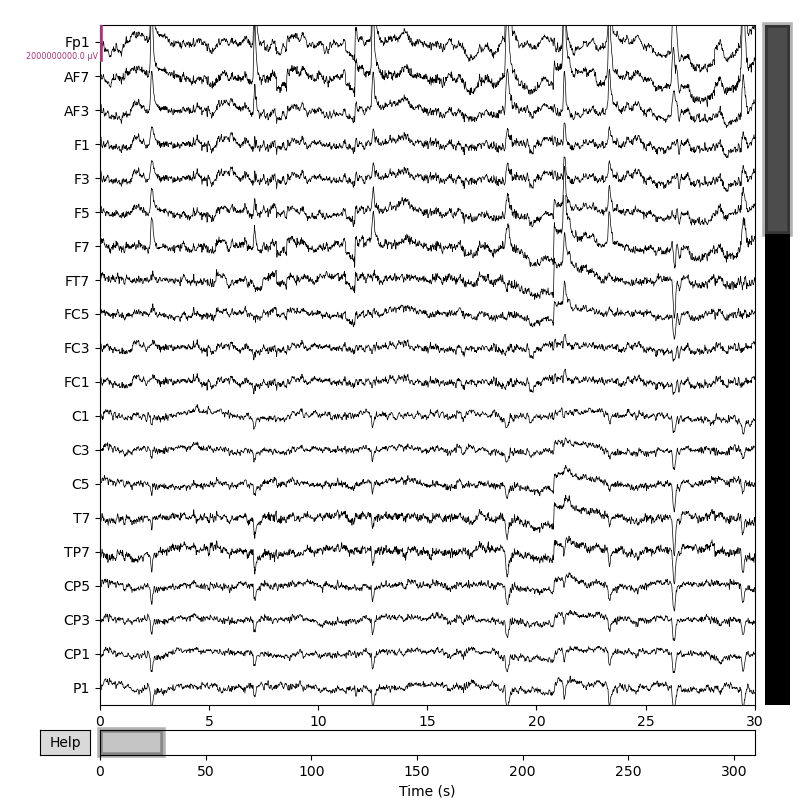

In [12]:
scalings = {'eeg': 1000, 'time': 100}
rawArr.plot(
    scalings = scalings,
    title=title_str,
    duration = 30
)
plt.show()

In [13]:
ev_array = mne.find_events(
    rawArr, 
    initial_event=True, # since the data was already sliced
)

eps = mne.Epochs(
    raw=rawArr, 
    #event_id=event_dict_thisTrial, 
    events=ev_array, 
    tmin=0,          # start of trial
    tmax=nrows/fs,   # end of trial 
    baseline=None, #(0,0),  # Don't baseline correct the epochs for ICA
    #metadata=metadata_envs
)
eps.set_montage('biosemi64')

11 events found
Event IDs: [1]
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


Number of events,11
Events,1: 11
Time range,0.000 – 28.172 sec
Baseline,off


In [14]:
ica = mne.preprocessing.ICA(n_components = len(chanLocs))

In [15]:
ica.fit(eps)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Using data from preloaded Raw for 11 events and 1804 original time points ...
1 bad epochs dropped
Selecting by number: 64 components


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_9489/2217224271.py:1: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(eps)


Using data from preloaded Raw for 10 events and 1804 original time points ...
Fitting ICA took 5.3s.


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_9489/2217224271.py:1: RuntimeWarning: Using n_components=64 (resulting in n_components_=64) may lead to an unstable mixing matrix estimation because the ratio between the largest (44) and smallest (2.2e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 63
  ica.fit(eps)


Method,fastica
Fit,310 iterations on epochs (18040 samples)
ICA components,64
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [16]:
%matplotlib inline

Using data from preloaded Raw for 10 events and 1804 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


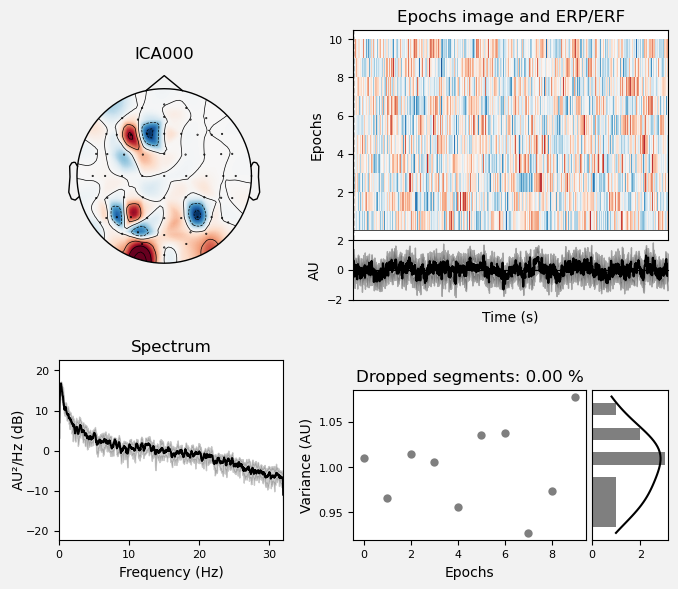

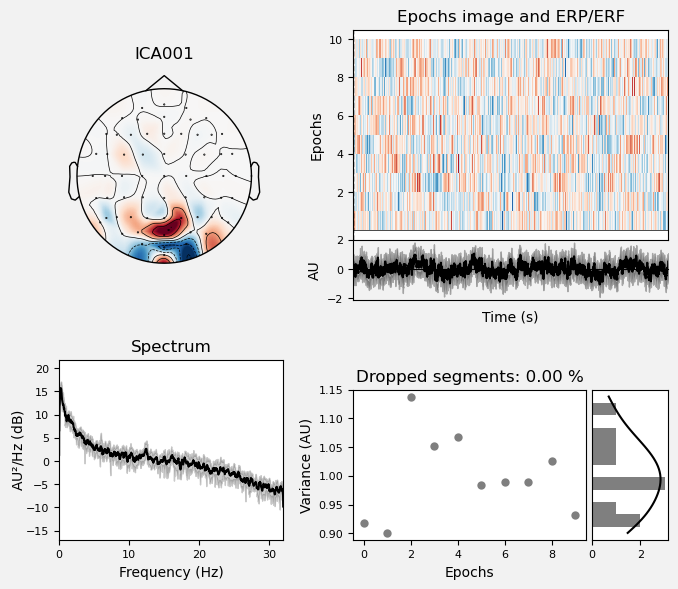

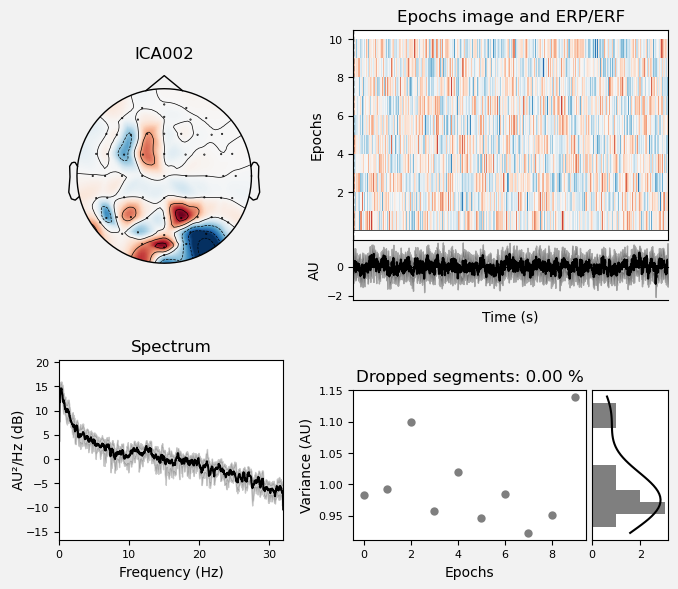

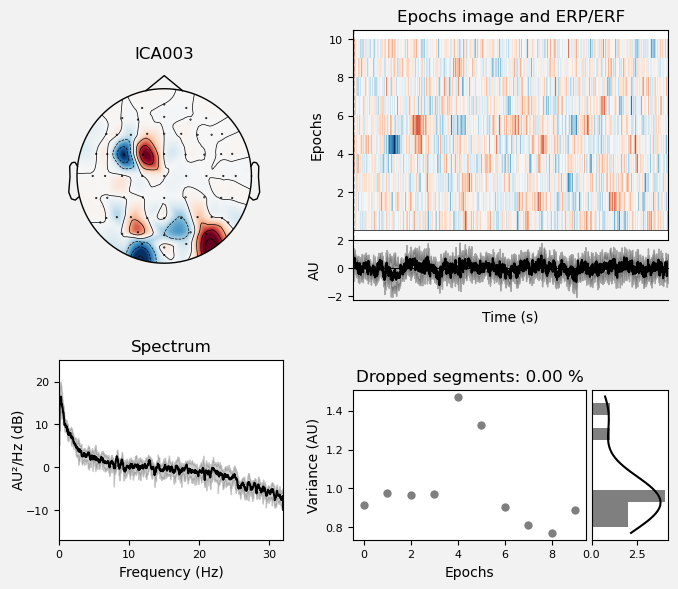

In [17]:
ica.plot_properties(eps, picks=range(4))
plt.show()

# Ocular Artifacts using 'eog' channels
Here we attempt to run MNE's in-built ocular artifact extraction by passing pre-frontal channels as 'eog' channels.

Channel | Type
:-- | :--
Fp1 | **'eog'**
Fp2 | **'eog'**
Fpz | **'eog'**
AF7, AF8, AFz | (skip)
Cz, F1, F2, T7, T8, O1, O2 | eeg

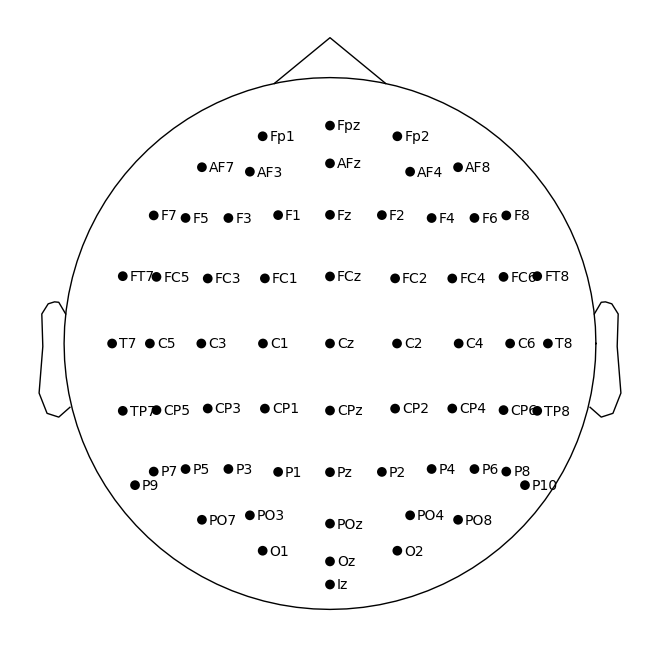

In [18]:
# Plot channel locations
biosemi64_montage = mne.channels.make_standard_montage('biosemi64')
biosemi64_montage.plot()  # 2D
plt.show()

In [19]:
'''
Don't use chanLocs and channel names are not standard
def getChanIdxs(chanLocs, targetChans, printChanLabels=False):
    # Go through chanLocs dict and find indices of channel labels matching targetChans
    
    targetIdxs = []
    
    # Make an ordered list of all channel labels
    chanLabels = [chanDict['labels'] for chanDict in chanLocs]
    if printChanLabels:
        print('Sorted:', sorted(chanLabels))
        
    # Lower case the labels just to make matching easier for user inputs
    chanLabels = [label.lower() for label in chanLabels]
    
    for ch in targetChans:
        chIdx = chanLabels.index(ch.lower())
        targetIdxs.append(chIdx)
        
    return targetIdxs
'''

# Pick channels to be labelled as 'eog'
targetEogChans = ['Fp1', 'Fp2', 'Fpz'] #, 'Fpz', 'AF7', 'AF8', 'AFz', 'Cz'] # Dataset uses 'Afz'

# Pick some channels to be passed as 'eeg'
targetEegChans = ['Cz', 'F1', 'F2', 'T7', 'T8', 'O1', 'O2']

# Combine the two
targetChans = targetEogChans + targetEegChans
# targetChanIdxs = getChanIdxs(montage_chs, targetChans, printChanLabels=True)

# Look for col indices of these channels
targetChanIdxs = []
for ch in targetChans:
    chIdx = montage_chs.index(ch)
    targetChanIdxs.append(chIdx)
print(targetChanIdxs)

[0, 33, 32, 47, 3, 38, 14, 51, 26, 63]


## Import Fp1/2 as 'eog' channels

In [20]:
FpX_data = all_trials_data[:, targetChanIdxs]

FpX_info = mne.create_info(
    ch_names=targetChans, #montage_chs + ['stim_014'], 
    sfreq=fs, 
    ch_types=['eog']*len(targetEogChans) + ['eeg']*len(targetEegChans), # + ['stim']
)

# Append stim channel to data
''' # Is this for rescaling data?
data_plus_stim = np.zeros((thisTrialData.shape[0]+1, thisTrialData.shape[1])) # 65, n_times
data_plus_stim[:thisTrialData.shape[0], :]=thisTrialData/10000000
'''

rawArrFpX = mne.io.RawArray( 
    data = FpX_data.T, # transpose for importing to MNE
    info = FpX_info,
    first_samp = 0 # have to check in on this parameter-- not sure what it is
)

rawArrFpX.set_montage('biosemi64')

Creating RawArray with float64 data, n_channels=10, n_times=19833
    Range : 0 ... 19832 =      0.000 ...   309.875 secs
Ready.


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_9489/3449534898.py:21: RuntimeWarning: Not setting positions of 3 eog channels found in montage:
['Fp1', 'Fp2', 'Fpz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  rawArrFpX.set_montage('biosemi64')


<RawArray | 10 x 19833 (309.9 s), ~1.5 MB, data loaded>

## Running steps from MNE's preprocessing overview
https://mne.tools/dev/auto_tutorials/preprocessing/10_preprocessing_overview.html#ocular-artifacts-eog

Using EOG channels: Fp1, Fp2, Fpz
EOG channel index for this subject is: [0 1 2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 640 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 89 significant peaks
Number of EOG events detected: 89
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 89 events and 65 original time points ...
0 bad epochs dropped
Not setting metadata
89 matching events found
No b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


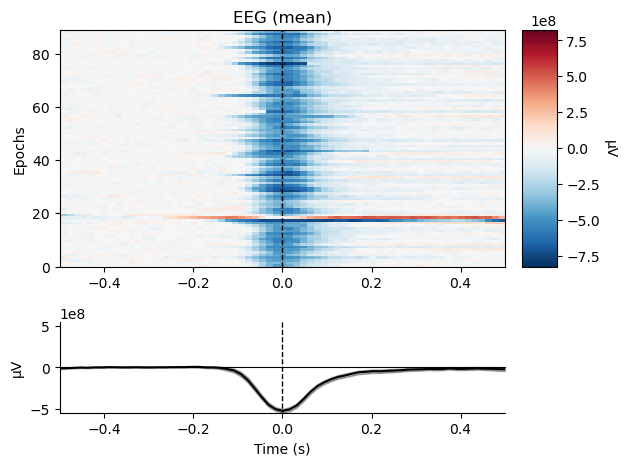

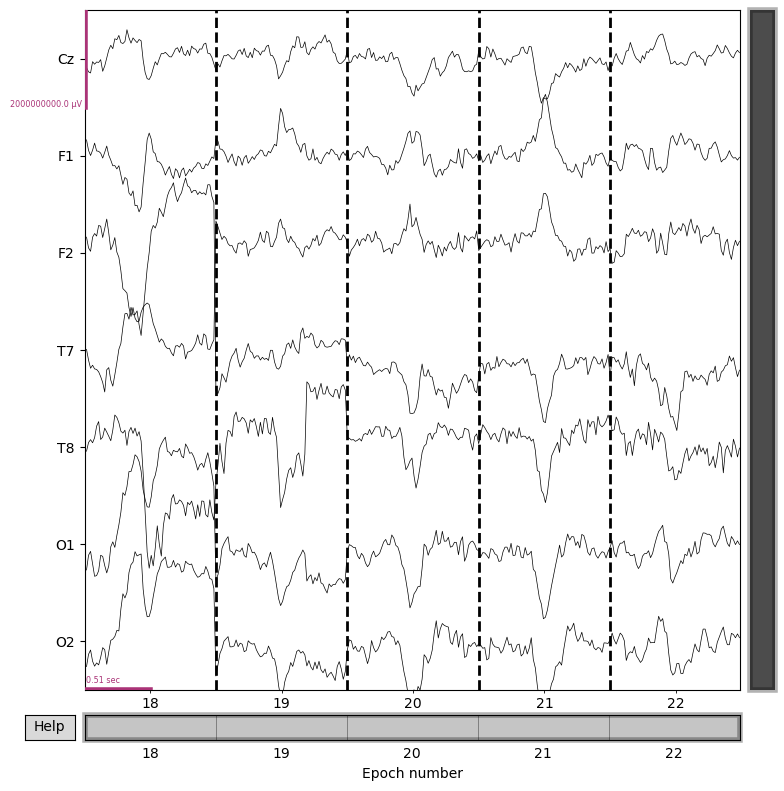

No projector specified for this dataset. Please consider the method self.add_proj.


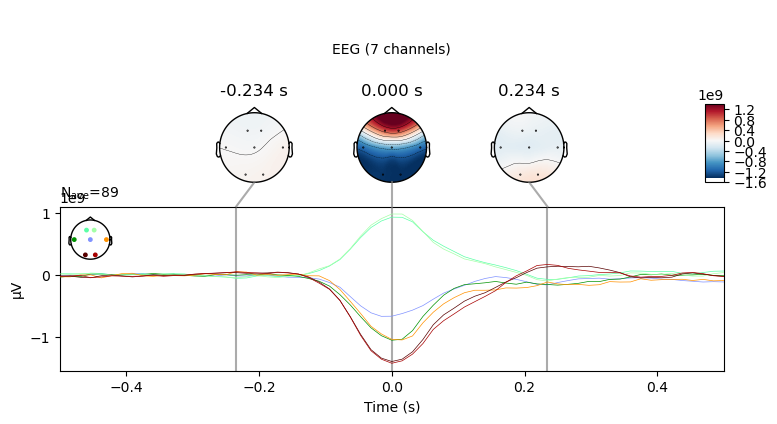

In [21]:
# Look for ocular artifacts
eog_epochs = mne.preprocessing.create_eog_epochs(
    rawArrFpX, 
    baseline=(-0.5, -0.2)
)

# Plot average of chosen EEG channels around detected eye blinks
eog_epochs.plot_image(combine='mean')

# Plot some suspicious looking epochs
eog_epochs[18:23].plot(scalings={'eeg': 1000})

# Compare averaged EEG channels
eog_epochs.average().plot_joint()

plt.show()

In [22]:
icaEog = mne.preprocessing.ICA(n_components = len(targetChans))
try:
    icaEog.fit(eog_epochs)
except ValueError as e:
    print(e)

Fitting ICA to data using 7 channels (please be patient, this may take a while)
ica.n_components (10) cannot be greater than len(picks) (7)


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_9489/690877452.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  icaEog.fit(eog_epochs)
/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_9489/690877452.py:3: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  icaEog.fit(eog_epochs)


In [23]:
icaEeg = mne.preprocessing.ICA(n_components = len(targetEegChans))
icaEeg.fit(eog_epochs)

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components
Fitting ICA took 0.0s.


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_9489/2776538199.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  icaEeg.fit(eog_epochs)
/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_9489/2776538199.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  icaEeg.fit(eog_epochs)


Method,fastica
Fit,21 iterations on epochs (5785 samples)
ICA components,7
Available PCA components,7
Channel types,eeg
ICA components marked for exclusion,—


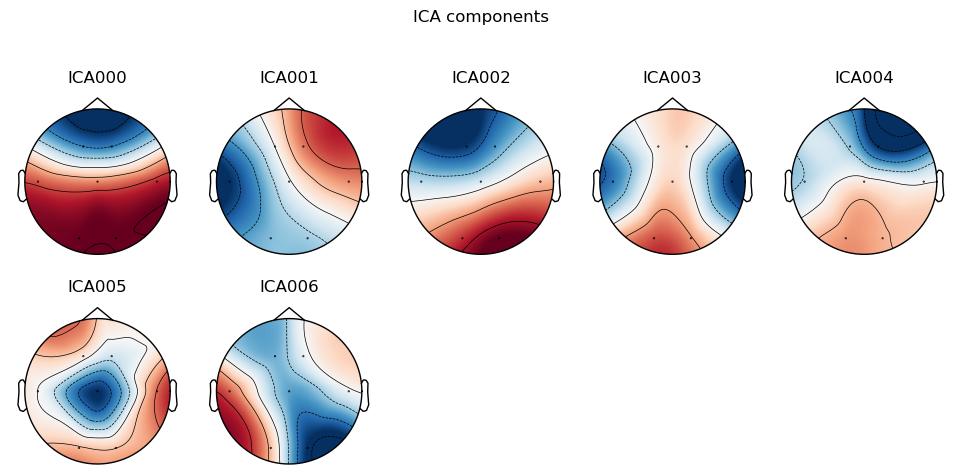

[<MNEFigure size 975x496 with 7 Axes>]

In [24]:
icaEeg.plot_components()

Using data from preloaded Raw for 10 events and 1804 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


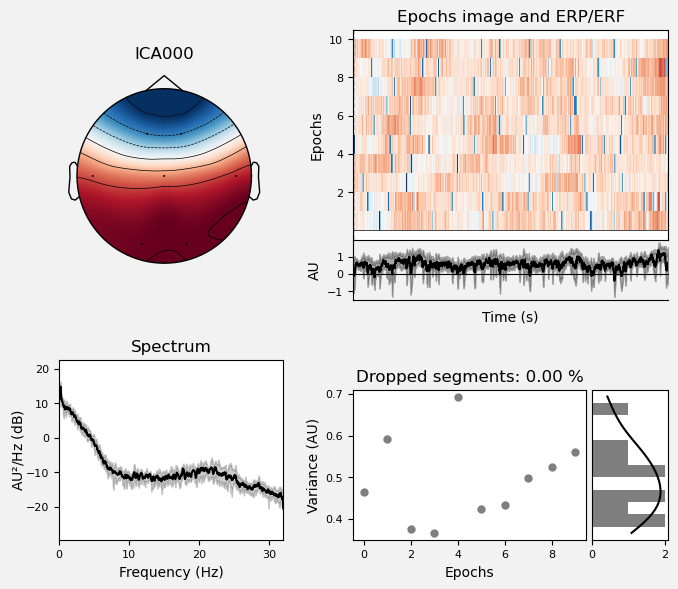

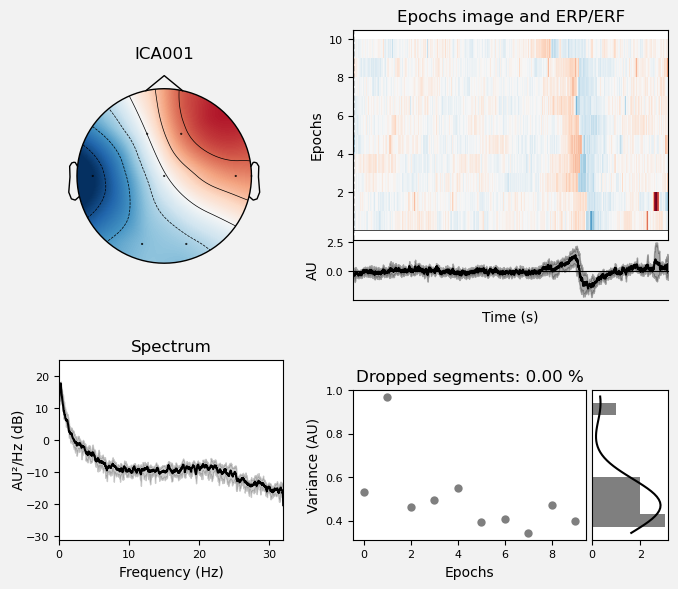

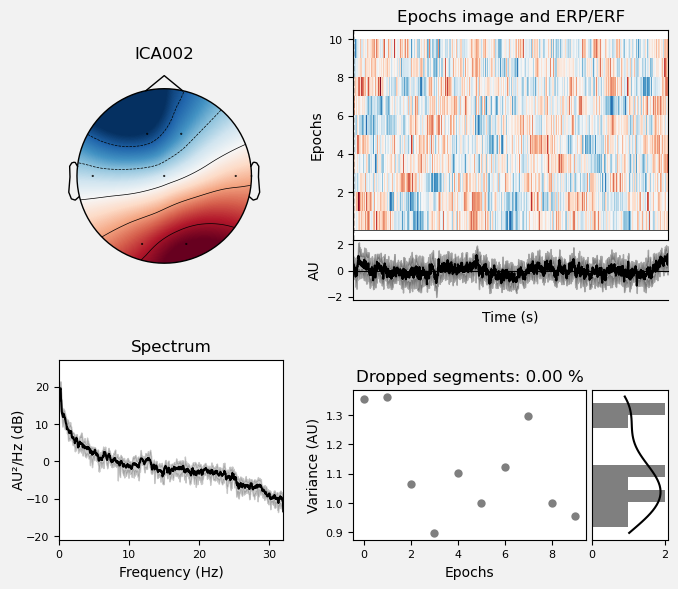

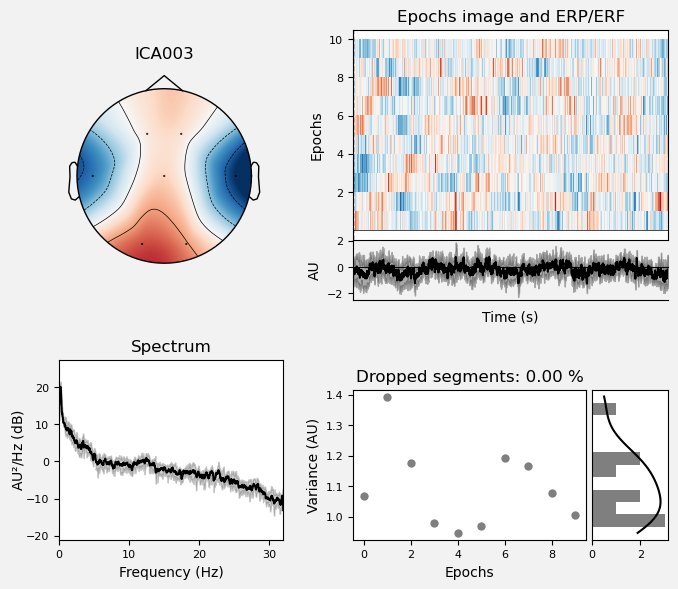

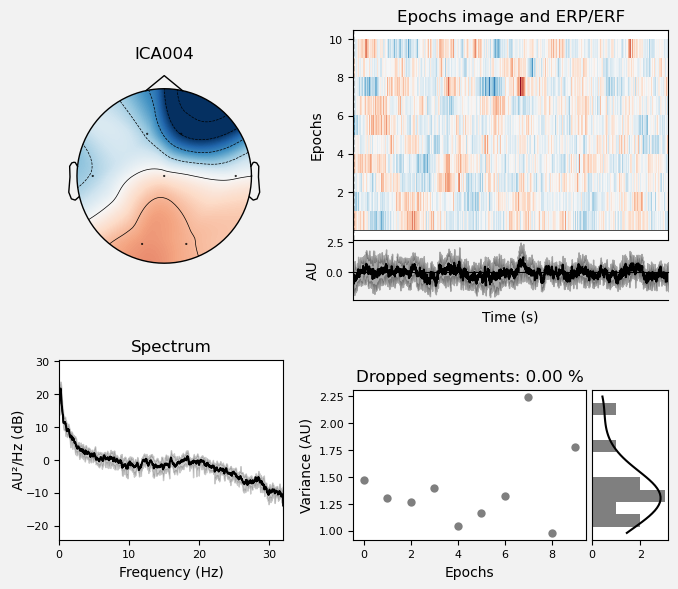

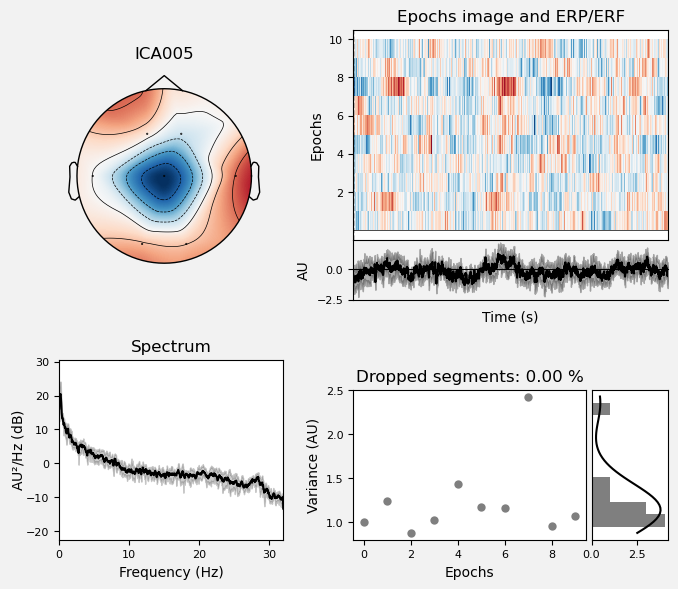

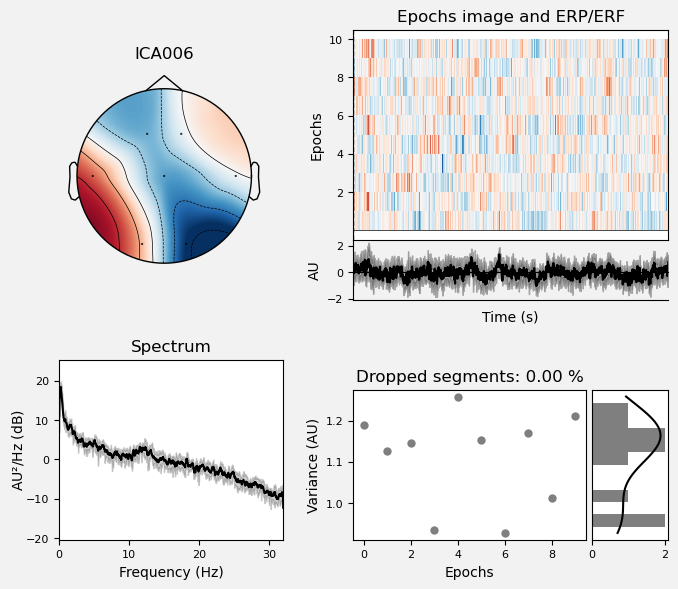

In [25]:
icaEeg.plot_properties(eps, picks=range(len(targetEegChans)))
plt.show()

To Do:
- plot time course of IC components
- find and exclude ICs with EOG events
https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html